# Simulating image formation through a microscope

## Prerequisites
- Image formation with ray traces
- Understand that a wave (light) going through an aperture (microscope pupil) will diffract (intereferences).
- Fourier transform / convolution
- 

## Aims
--> illustrate :
- microscope resolution and how input parameters affect it (NA, Wavelength,
- microscope PSF
- convolution of the sample image with the microscope PSF

## Follow up
- show how camera parameters affect final image (noise, pixel sampling, Gain, etc...)
- show how illumination schemes (Epi / TIRF / confocal) affect final image
- show how illumination schemes (Epi / TIRF / confocal) affect sectioning

## Installation

Packages to install:
- MicroscPSF-Py

```!python -m pip install MicroscPSF-Py```

## credits


## Simulating a 3D sample

Parameters:
sample_type : choose the sample to simulate

Advanced exercices:
- create a function to generate a 3D sample of your choice (single molecules with different itensities, 3D actin filaments, etc...)
- add a function to simulate an inhomogeneous excitation intensity
- 

In [1]:
import numpy as np


def sphere(shape, radius, position):
    # assume shape and position are both a 3-tuple of int or float
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    semisizes = (radius,) * 3

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below 1
    return arr <= 1.0

In [2]:
# Generate a sample (3D matrix)

# Sample parameters
pixel_size = 0.02   # in µm
FOV_size = 10      # in µm
depth = 5         # in µm
sample_type = "single_molecules"    # beads, single_molecules

# Generate sample
if sample_type is "beads":
  xy = int(FOV_size/pixel_size)
  zz = int(depth/pixel_size)
  sample = sphere((xy, xy, zz), 10, (50, 50, 10))*0.5 + sphere((xy, xy, zz), 4, (100, 100, 4)) + sphere((xy, xy, zz), 1, (150, 150, 1))*5 # plot in 3D
elif sample_type is "single_molecules":
  sample = np.zeros(( int(depth/pixel_size *  (FOV_size/pixel_size)**2),1))
  n_molecules = 100   # Number of molecules to generate
  ind = np.random.randint(0, depth*FOV_size**2/pixel_size**3, size=(n_molecules,))
  sample[list(ind)] = 1
  sample = sample.reshape((  int(FOV_size/pixel_size), int(FOV_size/pixel_size), int(depth/pixel_size)))
  print(sample.shape)




(500, 500, 250)


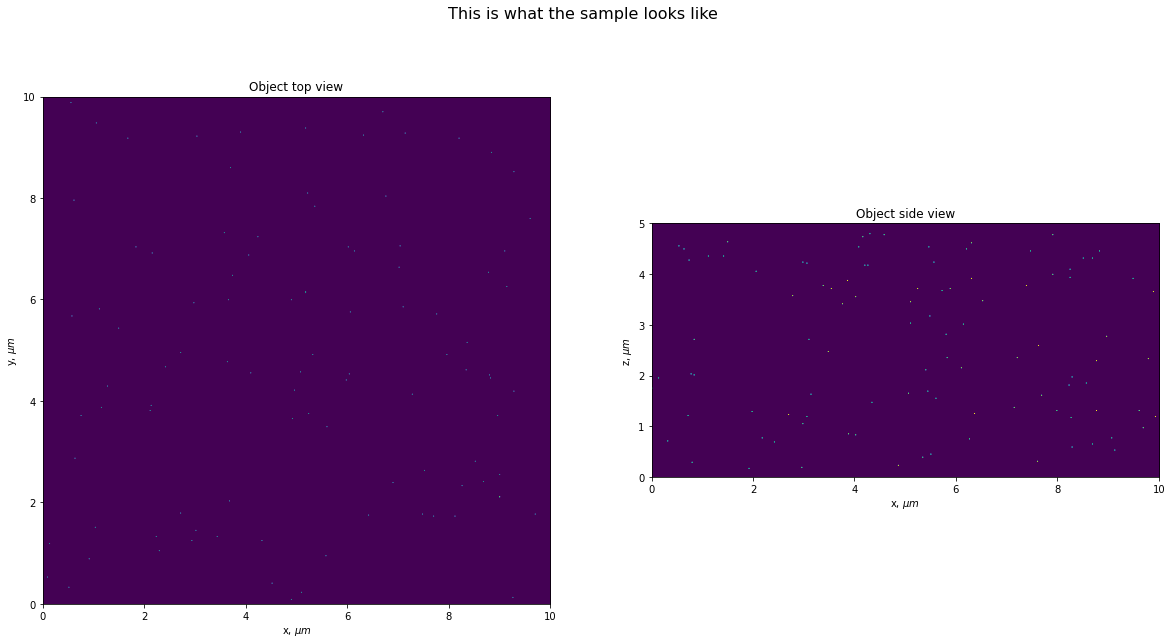

In [6]:
# Show it.
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,10))
fig.suptitle('This is what the sample looks like', fontsize=16)
extent = [0 , FOV_size, 0 , FOV_size]
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(sample.sum(axis=2), extent = extent)
ax1.set_title("Object top view")
ax1.set_xlabel(r'x, $\mu m$')
ax1.set_ylabel(r'y, $\mu m$')

extent = [0 , FOV_size, 0 , depth]
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(np.rot90(sample.sum(axis=1)), extent = extent)
ax2.set_title("Object side view")
ax2.set_xlabel(r'x, $\mu m$')
ax2.set_ylabel(r'z, $\mu m$')
plt.show()



## Simulating the microscope PSF

Parameters:
- msPSF.m_params : dictionnary with microscope objective and sample parameters:
            "M" : 100.0,             # magnification
            "NA" : 1.4,              # numerical aperture
            "ng" : 1.515,            # coverslip RI experimental value
            "ni" : 1.515,            # immersion medium RI experimental value
            "ns" : 1.33,             # specimen refractive index (RI)
            "tg0" : 170,             # microns, coverslip thickness design value
- wvl  : Light wavelength in microns.
- zv   : Microscope focused position above the coverslip.

Advanced exercices:
- Generate profiles accross sample strucutres to estimate the final resolution of the microscope
- Fit a single molecule profile with a Gaussian

In [8]:
# Install MicroscPSF-Py package
!python -m pip install MicroscPSF-Py

In [9]:
import inspect
import numpy
import matplotlib.pyplot as pyplot

import microscPSF.microscPSF as msPSF

# Set microscope objective parameters
msPSF.m_params['NA'] = 1.2  # specimen refractive index (RI)
msPSF.m_params['ns'] = 1.512  # specimen refractive index (RI)
print(msPSF.m_params)

{'M': 100.0, 'NA': 1.2, 'ng0': 1.515, 'ng': 1.515, 'ni0': 1.515, 'ni': 1.515, 'ns': 1.512, 'ti0': 150, 'tg': 170, 'tg0': 170, 'zd0': 200000.0}


In [10]:
# Load and print the default microscope parameters.
for key in sorted(msPSF.m_params):
    print(key, msPSF.m_params[key])
print()

# You can find more information about what these are in this file:
print(inspect.getfile(msPSF))

M 100.0
NA 1.2
ng 1.515
ng0 1.515
ni 1.515
ni0 1.515
ns 1.512
tg 170
tg0 170
ti0 150
zd0 200000.0

/usr/local/lib/python3.7/dist-packages/microscPSF/microscPSF.py


In [11]:
# Function for plotting PSFs.
#
# Note that we display the sqrt of the PSF.
#
def psfSlicePics(psf, sxy, sz, zvals, pixel_size = 0.05):
    ex = pixel_size * 0.5 * psf.shape[1]

    fig = pyplot.figure(figsize = (12,4))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(numpy.sqrt(psf[sz,:,:]),
               interpolation = 'none', 
               extent = [-ex, ex, -ex, ex],
               cmap = "gray")
    ax1.set_title("PSF XY slice")
    ax1.set_xlabel(r'x, $\mu m$')
    ax1.set_ylabel(r'y, $\mu m$')

    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(numpy.sqrt(psf[:,:,sxy]),
               interpolation = 'none',
               extent = [-ex, ex, zvals.max(), zvals.min()],
               cmap = "gray")
    ax2.set_title("PSF YZ slice")
    ax2.set_xlabel(r'y, $\mu m$')
    ax2.set_ylabel(r'z, $\mu m$')
    ax2.set_aspect(1)
        
    ax3 = fig.add_subplot(1,3,3)
    ax3.imshow(numpy.sqrt(psf[:,sxy,:]), 
               interpolation = 'none',
               extent = [-ex, ex, zvals.max(), zvals.min()],
               cmap = "gray")
    ax3.set_title("PSF XZ slice")
    ax3.set_xlabel(r'x, $\mu m$')
    ax3.set_ylabel(r'z, $\mu m$')
    ax3.set_aspect(1)

    pyplot.show()

/usr/local/lib/python3.7/dist-packages/microscPSF/microscPSF.py:214: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C, residuals, _, _ = numpy.linalg.lstsq(J.T, phase.T)


1.639344262295082


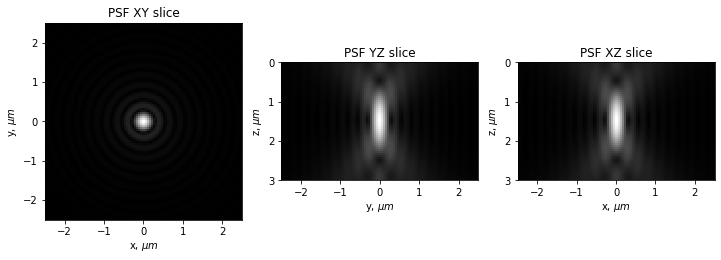

In [12]:
# PSF parameters
mp = msPSF.m_params                      # Objective specs
pixel_size = 0.05                        # Step size in the XY plane
pv = numpy.arange(0.0, 3.01, pixel_size) # Particle distance above coverslip in microns.
wvl = 0.6                                # Light wavelength in microns.
zv = -1.5                                # Microscope focused 1.5um above the coverslip.

# Generate 3D PSF
N_pix_XY = int(5/pixel_size)
psf_xyz = msPSF.gLXYZParticleScan(mp, 
                                  pixel_size,   # Step size in the XY plane
                                  N_pix_XY,     # Number of pixels in X/Y
                                  pv,           # particle z position above the coverslip, in µm
                                  wvl = wvl,    # Light wavelength in microns.
                                  zv = zv)      # Microscope focused 1.5um above the coverslip.
print(psf_xyz.shape[1]/psf_xyz.shape[0])
psfSlicePics(psf_xyz, int(N_pix_XY/2), int(1.5/pixel_size), pv)

## Convoluting the object with the microscope PSF


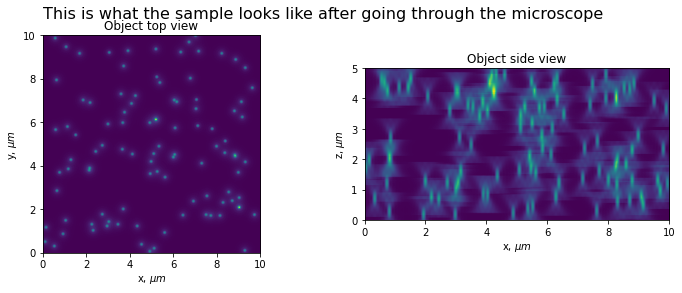

In [13]:
# Convolve the sample with the microscope PSF
import scipy.signal as sps
sample_conv = sps.fftconvolve(sample, np.moveaxis(psf_xyz, 0, -1), mode='same')

# Plot results
fig = pyplot.figure(figsize = (12,4))
fig.suptitle('This is what the sample looks like after going through the microscope', fontsize=16)
extent = [0 , FOV_size, 0 , FOV_size]
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(sample_conv.sum(axis=2), extent = extent)
ax1.set_title("Object top view")
ax1.set_xlabel('x, $\mu m$')
ax1.set_ylabel('y, $\mu m$')

extent = [0 , FOV_size, 0 , depth]
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(np.rot90(sample_conv.sum(axis=1)), extent = extent)
ax2.set_title("Object side view")
ax2.set_xlabel('x, $\mu m$')
ax2.set_ylabel('z, $\mu m$')
plt.show()